somewhere else, do:
```
git clone https://github.com/lsst/ip_diffim.git
cd ip_diffim
source ~/lsstsw/setup.csh
#setup -t b1813 ip_diffim
#setup -k -r .
setup -t 1813 -r .
scons
```

then you will want to add `$HOME/lsstsw/miniconda/lib/python2.7/site-packages` to your `PYTHONPATH` in order to be able to import `joblib` and friends.

now edit and run the code in here.

In [1]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')

from joblib import Parallel, delayed  
import multiprocessing

import pandas as pd
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

In [2]:
import sys
import numpy as np

import lsst.utils.tests as tests
import lsst.daf.base as dafBase
#import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.ip.diffim as ipDiffim

np.random.seed(666)

In [3]:
## Code updated from lsstsw/build/ip_diffim/tests/dipole.py

## Old code used a double gaussian psf which has the problem that it is pixel-oriented.
## Let's use afwMath.DoubleGaussianFunction2D() instead...
## Change parameterization to pixels - separation (in pixels) and psfWidth (pixels)

## Weird behavior, this fails the dipole lobes are not offset from each other in y direction (hence the +0.05 below...)
## or else we need to use 1,1 in the fpSet.merge() call below (instead of 0,0 which was in the original code)

def createDipole(w=100, h=100, xc=50., yc=50., separation=2.4, rotAngle=0.0, flux=3000.0, psfWidth=2.0, verbose=False,
                 display=False):  ## fracOffset = 1.2, psfSize=17, 
    # Make random noise image: set image plane to normal distribution
    image = afwImage.MaskedImageF(w,h)
    image.set(0)
    array = image.getImage().getArray()
    array[:,:] = np.random.randn(w,h)
    # Set variance to 1.0 -- TODO, should set variance after adding flux
    var   = image.getVariance()
    var.set(1.0)
        
    # Create Psf for dipole creation and measurement. Need a psf object too (for source detection below)
    psfSize = int(psfWidth * 20.) + 1
    psf = measAlg.DoubleGaussianPsf(psfSize, psfSize, psfWidth, psfWidth*1.75, 0.1) ## 2.0, 3.5, 0.1)
    generator = afwMath.DoubleGaussianFunction2D(psfWidth, psfWidth*1.75, 0.1)    

    psfim = psf.computeImage().convertF()
    psfim *= flux / np.sum(psfim.getArray())
    psfw, psfh = psfim.getDimensions()
    psfSum = np.sum(psfim.getArray())

    if display:
        #ds9.mtv(image, frame=1, title="Original image")
        #ds9.mtv(image.getVariance(), frame=2, title="Original variance")
        psf_arr = psf.computeImage().convertF().getArray()
        plt.imshow(np.rot90(psf_arr), cmap='gray', extent=(0,psfSize-1,0,psfSize-1), interpolation='none')
        plt.plot(psfw//2, psfw//2, 'bo')
        plt.title("PSF")
        plt.show()

    # Create the dipole separated by pixels instead of the old fracOffset of Psf FWHM
    # Assume rotAngle is in degrees
    rotAngRad = rotAngle / 180. * np.pi
    array  = image.getImage().getArray()
    xp, yp = xc + separation/2. * np.cos(rotAngRad), yc + separation/2. * np.sin(rotAngRad)
    imPos = np.ndarray( (w,h), buffer=np.array([ generator(i-xp,j-yp) for i in xrange(w) for j in xrange(h) ]) )
    array[:] += imPos/np.sum(imPos)*flux
    psfSum = np.sum(imPos/np.sum(imPos)*flux) # get more accurate input "flux"

    xn, yn = xc - separation/2. * np.cos(rotAngRad), yc - separation/2. * np.sin(rotAngRad)
    imNeg = np.ndarray( (w,h), buffer=np.array([ generator(i-xn,j-yn) for i in xrange(w) for j in xrange(h) ]) )
    array[:] -= imNeg/np.sum(imNeg)*flux
    
    if verbose:
        print 'INPUT CENTROID: ', xc, yc
        print 'INPUT ANGLE: ', rotAngle, rotAngRad
        print 'INPUT POSITIVE CENTROID:', xp, yp
        print 'INPUT NEGATIVE CENTROID:', xn, yn
    dipoleCenters = {'pos': (xp, yp), 'neg': (xn, yn)}

    # Create an exposure, detect positive and negative peaks separately
    # Need to create a psf object anyway, so that's why we did it above, same parameters as the function.
    
    exp = afwImage.makeExposure(image)
    exp.setPsf(psf)

    if display:
        #ds9.mtv(image, frame=3, title="With dipole")
        img_arr, mask_arr, var_arr = exp.getMaskedImage().getArrays()
        plt.title("Original image with dipole")
        plt.imshow(np.rot90(img_arr), vmin=img_arr.min(), vmax=img_arr.max(), cmap='gray', extent=(0,w-1,0,h-1), interpolation='none')
        plt.plot(xp, yp, 'bx')
        plt.plot(xn, yn, 'bx')
        ##plt.show()
        
    return psf, psfSum, exp, dipoleCenters
    
def detectDipoleSources(exposure, verbose=False, display=False):
    # Detect positive and negative sources in the image. This should be moved to a separate function.
    # See meas_algorithms/python/lsst/meas/algorithms/detection.py (SourceDetectionConfig) for config params
    config = measAlg.SourceDetectionConfig()
    config.thresholdPolarity = "both"
    config.reEstimateBackground = True
    # config.thresholdValue = 5.0   ## how do we set the detection threshold? Default is 5 sigma, set via config.thresholdValue
    schema = afwTable.SourceTable.makeMinimalSchema()  
    task = measAlg.SourceDetectionTask(schema, config=config)
    table = afwTable.SourceTable.make(schema)
    results = task.makeSourceCatalog(table, exposure)
#     if display:
#         ds9.mtv(image, frame=4, title="Detection plane")
        
    # Merge them together
    assert(len(results.sources) == 2)
    fpSet = results.fpSets.positive
    fpSet.merge(results.fpSets.negative, 1, 1, False) ## note used to be tGrow=0, rGrow=0, but sometimes sources were not merged.
    sources = afwTable.SourceCatalog(table)
    fpSet.makeSources(sources)
    assert(len(sources) == 1)
    s = sources[0]
    assert(len(s.getFootprint().getPeaks()) == 2)

    if verbose:
        for pk in s.getFootprint().getPeaks():
            print 'FOOTPRINT CENTER:', pk.getIy(), pk.getIx()

    if display:
        img_arr, mask_arr, var_arr = exposure.getMaskedImage().getArrays()
        plt.title("Original image with dipole")
        plt.imshow(np.rot90(img_arr), vmin=img_arr.min(), vmax=img_arr.max(), cmap='gray', extent=(0,w-1,0,h-1), interpolation='none')
        plt.plot(xp, yp, 'bx')
        plt.plot(xn, yn, 'bx')

        ## first overlay the fp centers on the input image and show it.
        for pk in s.getFootprint().getPeaks():
            plt.plot(pk.getIy(), pk.getIx(), 'rx')
        plt.show()

        img_arr, mask_arr, var_arr = exposure.getMaskedImage().getArrays()
        plt.title("Detection plane")
        plt.imshow(np.rot90(mask_arr), vmin=-100, vmax=100, cmap='gray', extent=(0,w-1,0,h-1), interpolation='none')
        for pk in s.getFootprint().getPeaks():
            plt.plot(pk.getIy(), pk.getIx(), 'rx')
        plt.show()
        
    return s

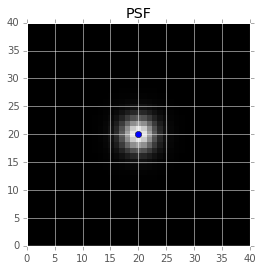

INPUT CENTROID:  25 25
INPUT ANGLE:  0.0 0.0
INPUT POSITIVE CENTROID: 26.2 25.0
INPUT NEGATIVE CENTROID: 23.8 25.0
3000.0 {'neg': (23.800000000000001, 25.0), 'pos': (26.199999999999999, 25.0)}
CENTROID:  (25.0, 25.0)


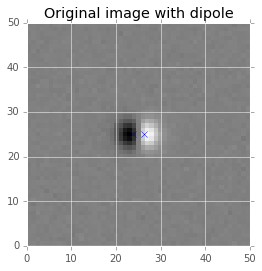

In [4]:
#w, h = 51, 51 # size of image
#xc, yc = 25, 25 # location of center of dipole
psf, psfSum, exposure, dipoleCenters = createDipole(51, 51, 25, 25, separation=2.4, rotAngle=0., verbose=True, display=True)
print psfSum, dipoleCenters
s = detectDipoleSources(exposure)
dipoleCentroid = (np.mean([dipoleCenters['neg'][0], dipoleCenters['pos'][0]]), np.mean([dipoleCenters['neg'][1], dipoleCenters['pos'][1]]))
print 'CENTROID: ', dipoleCentroid

In [5]:
## I think this is the meat of the code that runs the measurement. How do I get the complete set of (fitted) parameters out? 
## THat is the question!
## OK, figured it out, see below...
def measureDipole(s, exp):
    msConfig = ipDiffim.DipoleMeasurementConfig()
    schema = afwTable.SourceTable.makeMinimalSchema()
    schema.addField("centroid_x", type=float)
    schema.addField("centroid_y", type=float)
    schema.addField("centroid_flag", type='Flag')
    task = ipDiffim.DipoleMeasurementTask(schema, config=msConfig)
    measCat = afwTable.SourceCatalog(schema)
    measCat.defineCentroid("centroid")
    source = measCat.addNew()
    source.set("centroid_x", dipoleCentroid[0])
    source.set("centroid_y", dipoleCentroid[1])
    source.setFootprint(s.getFootprint())

    #print 'DIPOLE: ', source.get("classification_dipole") ## from ipDiffim.DipoleMeasurementTask._ClassificationFlag
    # Then run the default SFM task.  Results not checked
    task.run(measCat, exp)
    return measCat  ##[0] 

OK, I see that measureDipole is slow because of the psf fitting - in `DipoleAlgorithms.cc`. It seems to take nearly 1s for some fits (especially for closely-separated dipoles).

UPDATE - after compiling with O3, the dipole fitting is ~60ms now!

Why is it slow? Possible reasons:

1. `PsfDipoleFlux::chi2()` computes the PSF *image* (pos. and neg.) to compute the model, rather than using something like `afwMath.DoubleGaussianFunction2D()` as I do above. Or if that is not possible (may need to use a pixelated input PSF) then speed up the computation of the dipole model image (right now it uses multiple vectorized function calls).
2. It spends a lot of time floating around near the minimum and perhaps can be cut off more quickly (note this could be caused by (1.)
3. Perhaps its starting parameters (derived from the naive coordinates) could be made more accurate. At least it looks like the starting flux values are being set way too low (looks like +/- 22.0, should be ~3000 -- how is that being set?)
4. it computes chi2 over the entire subimage (confirm this?) rather than the inner 2,3,4, or 5 sigma of the PSF (or even better within the source's footprint(s)

Need to check out -- maybe because dipole fit is so slow, it's not enabled in the main pipelines, thus it uses the naive method by default which is inaccurate.

Note: It seems that the dipole fit is a lot faster for dipoles of greater separation than for those that are closer (it seems the optimization [minuit]) takes longer to converge).

But for now, let's just test the algorithm and worry about timing later.

In [6]:
#print 'DIPOLE: ' + s.get(dipoleFlag)
#%timeit measureDipole(s, exposure)
sources = measureDipole(s, exposure)
print 'DIPOLE: ', sources[0].get("classification_dipole") ## from ipDiffim.DipoleMeasurementTask._ClassificationFlag
source = sources[0]
fp     = source.getFootprint()
peaks  = fp.getPeaks()
speaks = [(p.getPeakValue(), p) for p in peaks]
speaks.sort()
dpeaks = [speaks[0][1], speaks[-1][1]]
print dpeaks
##print source.schema
print source.getCentroid() ## This just returns the values set in the "source.set("centroid_x", xc), ..." lines... ??
print source.get("ip_diffim_NaiveDipoleCentroid_pos_x"), source.get("ip_diffim_NaiveDipoleCentroid_pos_y"), \
    source.get("ip_diffim_NaiveDipoleCentroid_neg_x"), source.get("ip_diffim_NaiveDipoleCentroid_neg_y")
print source.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"), \
    source.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_neg_centroid_y")
print source.get("ip_diffim_PsfDipoleFlux_pos_flux"), source.get("ip_diffim_PsfDipoleFlux_neg_flux")

(25.0, 25.0)
DIPOLE:  1.0
[2: (25,22)  (25.000,22.000), 1: (25,28)  (25.000,28.000)]
(25, 25)
24.9972286224 27.8273792267 24.9936637878 22.1722164154
24.9990826381 26.2610026278 24.9891287233 23.734069582
2897.32972238 -2906.61016434


In [8]:
## NOT RUN:
if False:
    img_arr, _, _ = exposure.getMaskedImage().getArrays()
    import cPickle as pickle
    pickle.dump( img_arr, open( "save.p", "wb" ) )

In [7]:
## provides (S/N, position, orientation) of measured dipoles
dpAnalysis = ipDiffim.DipoleAnalysis()
sn, centroid, orientation = dpAnalysis(source)
print sn, centroid, orientation

71.3469377793 (24.994, 24.998) 0.00393911 rad


In [8]:
## deblend a source as a dipole, and return a new source with deblended footprints.
dpDeblender = ipDiffim.DipoleDeblender()
deblendedSource = dpDeblender(source, exposure)
print deblendedSource.getCentroid()
print deblendedSource.get("ip_diffim_NaiveDipoleCentroid_pos_x"), deblendedSource.get("ip_diffim_NaiveDipoleCentroid_pos_y"), \
    deblendedSource.get("ip_diffim_NaiveDipoleCentroid_neg_x"), deblendedSource.get("ip_diffim_NaiveDipoleCentroid_neg_y")
print deblendedSource.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), deblendedSource.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"), \
    deblendedSource.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), deblendedSource.get("ip_diffim_PsfDipoleFlux_neg_centroid_y")
print deblendedSource.get("ip_diffim_PsfDipoleFlux_pos_flux"), deblendedSource.get("ip_diffim_PsfDipoleFlux_neg_flux")

(25, 25)
24.9972286224 27.8273792267 24.9936637878 22.1722164154
24.9990826381 26.2610026278 24.9891287233 23.734069582
2897.32972238 -2906.61016434


In [9]:
from collections import namedtuple
resultsOutput = namedtuple('resultsOutput', 
        'inputCentroidX inputCentroidY inputSeparation inputRotation inputFlux inputPosCentroidX inputPosCentroidY inputNegCentroidX inputNegCentroidY psfFitPosCentroidX psfFitPosCentroidY psfFitNegCentroidX psfFitNegCentroidY psfFitPosFlux psfFitNegFlux psfFitCentroidX psfFitCentroidY psfFitOrientation psfFitSignaltoNoise')

def makeDipoleAndTestDipoleFit(w=100, h=100, xc=50., yc=50., separation=2.4, rotAngle=0.0, flux=3000.0, psfWidth=2.0, verbose=False):
    s = None
    nTries = 0
    while s is None and nTries < 100:
        try:
            nTries +=1
            psf, psfSum, exposure, dipoleCenters = createDipole(w, h, xc, yc, separation=separation, rotAngle=rotAngle, 
                                                                flux=flux, psfWidth=psfWidth, verbose=verbose, display=False)
            s = detectDipoleSources(exposure)
        except:
            pass
        
    if nTries >= 100:   ## probably too-low s/n to detect 2 sources.
        out = resultsOutput(xc, yc, separation, rotAngle, flux, np.nan, np.nan, np.nan, np.nan,
                            np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.inf)
        return out
    
    if verbose: print psfSum, dipoleCenters
    dipoleCentroid = (np.mean([dipoleCenters['pos'][0], dipoleCenters['neg'][0]]), np.mean([dipoleCenters['pos'][1], dipoleCenters['neg'][1]]))
    if verbose: print 'CENTROID: ', dipoleCentroid
    
    sources = measureDipole(s, exposure)
    if verbose: print 'DIPOLE: ', sources[0].get("classification_dipole") ## from ipDiffim.DipoleMeasurementTask._ClassificationFlag
    source = sources[0]
    fp     = source.getFootprint()
    peaks  = fp.getPeaks()
    speaks = [(p.getPeakValue(), p) for p in peaks]
    speaks.sort()
    dpeaks = [speaks[0][1], speaks[-1][1]]
    if verbose: 
        print dpeaks
        ##print source.schema
        print source.getCentroid() ## This just returns the values set in the "source.set("centroid_x", xc), ..." lines... ??
        print source.get("ip_diffim_NaiveDipoleCentroid_pos_x"), source.get("ip_diffim_NaiveDipoleCentroid_pos_y"), \
            source.get("ip_diffim_NaiveDipoleCentroid_neg_x"), source.get("ip_diffim_NaiveDipoleCentroid_neg_y")
        print source.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"), \
            source.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_neg_centroid_y")
        print source.get("ip_diffim_PsfDipoleFlux_pos_flux"), source.get("ip_diffim_PsfDipoleFlux_neg_flux")  
    
    ## provides (S/N, position, orientation) of measured dipoles
    dpAnalysis = ipDiffim.DipoleAnalysis()
    sn, centroid, orientation = dpAnalysis(source)
    if verbose: print sn, centroid, orientation
        
    out = resultsOutput(xc, yc, separation, rotAngle, flux,
        dipoleCenters['pos'][0], dipoleCenters['pos'][1], dipoleCenters['neg'][0], dipoleCenters['neg'][1], 
        source.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"),
        source.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_neg_centroid_y"),
        source.get("ip_diffim_PsfDipoleFlux_pos_flux"), source.get("ip_diffim_PsfDipoleFlux_neg_flux"),
        centroid.getX(), centroid.getY(), orientation, sn)
    
#     return (source.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"), 
#             source.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_neg_centroid_y"), 
#             sn, centroid, orientation)
    return out

In [10]:
makeDipoleAndTestDipoleFit(w=51, h=51, xc=25., yc=25., psfWidth=2.0, separation=2.4, rotAngle=0.0, flux=3000.0, verbose=True)

INPUT CENTROID:  25.0 25.0
INPUT ANGLE:  0.0 0.0
INPUT POSITIVE CENTROID: 26.2 25.0
INPUT NEGATIVE CENTROID: 23.8 25.0
3000.0 {'neg': (23.800000000000001, 25.0), 'pos': (26.199999999999999, 25.0)}
CENTROID:  (25.0, 25.0)
DIPOLE:  1.0
[16: (25,22)  (25.000,22.000), 15: (25,28)  (25.000,28.000)]
(25, 25)
24.9941616058 27.8339939117 24.9986019135 22.1729125977
25.0059319087 26.2444893767 25.0025292022 23.7721522531
2931.3594375 -2918.02167102
68.0379457376 (25.004, 25.008) 0.00137631 rad


resultsOutput(inputCentroidX=25.0, inputCentroidY=25.0, inputSeparation=2.4, inputRotation=0.0, inputFlux=3000.0, inputPosCentroidX=26.199999999999999, inputPosCentroidY=25.0, inputNegCentroidX=23.800000000000001, inputNegCentroidY=25.0, psfFitPosCentroidX=25.00593190865266, psfFitPosCentroidY=26.244489376736844, psfFitNegCentroidX=25.002529202172347, psfFitNegCentroidY=23.772152253051143, psfFitPosFlux=2931.3594374982376, psfFitNegFlux=-2918.0216710199347, psfFitCentroidX=25.004230555412505, psfFitCentroidY=25.00832081489399, psfFitOrientation=0.00137631 rad, psfFitSignaltoNoise=68.037945737560079)

In [11]:
makeDipoleAndTestDipoleFit(w=51, h=51, xc=25., yc=25., psfWidth=2.0, separation=0.25, rotAngle=90.0, flux=500.0)

resultsOutput(inputCentroidX=25.0, inputCentroidY=25.0, inputSeparation=0.25, inputRotation=90.0, inputFlux=500.0, inputPosCentroidX=nan, inputPosCentroidY=nan, inputNegCentroidX=nan, inputNegCentroidY=nan, psfFitPosCentroidX=nan, psfFitPosCentroidY=nan, psfFitNegCentroidX=nan, psfFitNegCentroidY=nan, psfFitPosFlux=nan, psfFitNegFlux=nan, psfFitCentroidX=nan, psfFitCentroidY=nan, psfFitOrientation=nan, psfFitSignaltoNoise=inf)

Note the output seems to have switched X and Y -- is this on purpose or my misunderstanding?

But for now we will just compare inputX with outputY and vice versa.

Test: do 10 repetitions at slowing increasing separations. This will probably fail due to exceptions being raised. Note these are all horizontally-aligned dipoles.

### Horizontally-aligned dipoles with increasing separation

In [12]:
results = [makeDipoleAndTestDipoleFit(w=51, h=51, xc=25., yc=25., psfWidth=2.0, separation=sep, rotAngle=0.0, flux=3000.0)
          for i in xrange(10) for sep in np.arange(0.2,5.0,0.2)]

In [13]:
df = pd.DataFrame([res._asdict() for res in results])

/Users/dreiss/miniconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


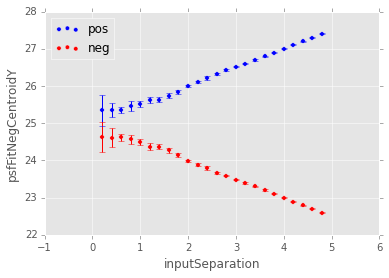

In [14]:
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='psfFitPosCentroidY', kind='scatter', yerr=tmp_df2['psfFitPosCentroidY'], color='blue', label='pos')
tmp_df.plot(x='inputSeparation', y='psfFitNegCentroidY', kind='scatter', yerr=tmp_df2['psfFitNegCentroidY'], color='red', label='neg', ax=ax)

In [15]:
df['diffCentroidPos'] = df.psfFitPosCentroidY - df.inputPosCentroidX
df['diffCentroidNeg'] = df.psfFitNegCentroidY - df.inputNegCentroidX

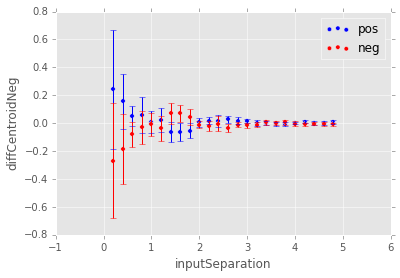

In [16]:
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='diffCentroidPos', kind='scatter', yerr=tmp_df2['diffCentroidPos'], color='blue', label='pos')
tmp_df.plot(x='inputSeparation', y='diffCentroidNeg', kind='scatter', yerr=tmp_df2['diffCentroidNeg'], color='red', label='neg', ax=ax)

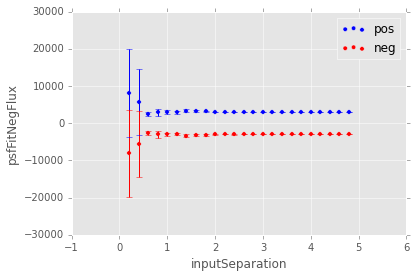

In [17]:
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='psfFitPosFlux', kind='scatter', yerr=tmp_df2['psfFitPosFlux'], color='blue', label='pos')
tmp_df.plot(x='inputSeparation', y='psfFitNegFlux', kind='scatter', yerr=tmp_df2['psfFitNegFlux'], color='red', label='neg', ax=ax)

Hmm, it looks like it sometime switches which is the pos- and neg- lobes. Let's take a closer look...

In [18]:
df[df.psfFitPosFlux < 0.]
df.ix[np.argmax(df.psfFitNegFlux)]

inputCentroidX                     25
inputCentroidY                     25
inputFlux                        3000
inputNegCentroidX                24.9
inputNegCentroidY                  25
inputPosCentroidX                25.1
inputPosCentroidY                  25
inputRotation                       0
inputSeparation                   0.2
psfFitCentroidX               25.2285
psfFitCentroidY               25.0226
psfFitNegCentroidX            25.2637
psfFitNegCentroidY            23.8526
psfFitNegFlux                -295.394
psfFitOrientation      -0.0300571 rad
psfFitPosCentroidX            25.1933
psfFitPosCentroidY            26.1926
psfFitPosFlux                 281.714
psfFitSignaltoNoise           5.97249
diffCentroidPos               1.09261
diffCentroidNeg              -1.04741
Name: 24, dtype: object

OK, see notebook #3a. to see what might be going on (answer - it's just that at close separations for big FWHM, it's hard.)

Try it again, this time setting different orientations as well. Next time we'll also test it as a function of source flux.

### Different orientations

In [19]:
from joblib import Parallel, delayed  
import multiprocessing

## Cool, get argument names for the function, and turn it into a named tuple...
varNames = makeDipoleAndTestDipoleFit.__code__.co_varnames[:makeDipoleAndTestDipoleFit.__code__.co_argcount]
varTuple = namedtuple("varTuple", varNames)

orientations = np.arange(0.0, 360.0, 36.0)
separations = np.arange(0.2, 5.0, 0.2)

inputs = [varTuple(w=51, h=51, xc=25., yc=25., psfWidth=2.0, separation=sep, rotAngle=rot, 
                         flux=3000.0, verbose=False) for rot in orientations for sep in separations]

def processInput(i):
    #print i.separation, i.rotAngle
    output = makeDipoleAndTestDipoleFit(w=i.w, h=i.h, xc=i.xc, yc=i.yc, psfWidth=i.psfWidth, separation=i.separation, 
                               rotAngle=i.rotAngle, flux=i.flux, verbose=i.verbose)
    return output


num_cores = multiprocessing.cpu_count() / 2
##print num_cores

# results2 = [makeDipoleAndTestDipoleFit(w=51, h=51, xc=25., yc=25., psfWidth=2.0, separation=sep, rotAngle=rot[i], 
#                                        flux=3000.0) for rot in orientations for sep in separations]
results2 = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)
# results2 = [processInput(i) for i in inputs]

In [20]:
df = pd.DataFrame([res._asdict() for res in results2])
print df.shape
df['rmsCentroidPos'] = np.sqrt((df.inputPosCentroidX - df.psfFitPosCentroidY)**2. + \
                               (df.inputPosCentroidY - df.psfFitPosCentroidX)**2.)

df['rmsCentroidNeg'] = np.sqrt((df.inputNegCentroidX - df.psfFitNegCentroidY)**2. + \
                               (df.inputNegCentroidY - df.psfFitNegCentroidX)**2.)

#df['rmsCentroidPos2'] = np.sqrt((df.inputPosCentroidX - df.psfFitPosCentroidX)**2. + \
#                               (df.inputPosCentroidY - df.psfFitPosCentroidY)**2.)
#df['rmsCentroidNeg2'] = np.sqrt((df.inputNegCentroidX - df.psfFitNegCentroidX)**2. + \
#                               (df.inputNegCentroidY - df.psfFitNegCentroidY)**2.)
sizeme(df.head())

(240, 19)


,inputCentroidX,inputCentroidY,inputFlux,inputNegCentroidX,inputNegCentroidY,inputPosCentroidX,inputPosCentroidY,inputRotation,inputSeparation,psfFitCentroidX,...,psfFitNegCentroidX,psfFitNegCentroidY,psfFitNegFlux,psfFitOrientation,psfFitPosCentroidX,psfFitPosCentroidY,psfFitPosFlux,psfFitSignaltoNoise,rmsCentroidPos,rmsCentroidNeg
0,25,25,3000,24.9,25,25.1,25,0,0.2,24.993340,...,24.994032,24.967255,-2978.887186,-0.00755576 rad,24.992648,25.150418,2990.903727,33.267836,0.050951,0.067519
1,25,25,3000,24.8,25,25.2,25,0,0.4,24.999066,...,25.000249,24.725502,-1913.489107,-0.00395446 rad,24.997883,25.323822,1925.245552,2.071697,0.123840,0.074498
2,25,25,3000,24.7,25,25.3,25,0,0.6,24.999357,...,25.000288,24.650426,-2387.158402,-0.00255086 rad,24.998425,25.380735,2398.767971,3.793766,0.080751,0.049575
3,25,25,3000,24.6,25,25.4,25,0,0.8,24.999468,...,25.000266,24.593835,-2796.332090,-0.00191084 rad,24.998670,25.429486,2808.178078,5.426742,0.029516,0.006171
4,25,25,3000,24.5,25,25.5,25,0,1.0,24.994551,...,24.995551,24.583136,-3691.402503,-0.00243724 rad,24.993551,25.403512,3699.017857,6.739786,0.096704,0.083255


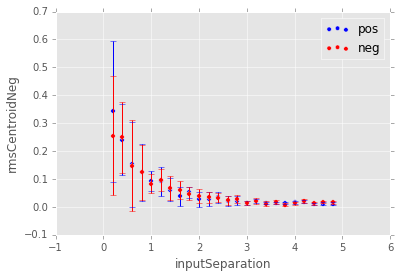

In [21]:
tmp_df = df.groupby('inputSeparation').median()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').mad() * 1.
ax = tmp_df.plot(x='inputSeparation', y='rmsCentroidPos', kind='scatter', yerr=tmp_df2['rmsCentroidPos'], color='blue', label='pos')
tmp_df.plot(x='inputSeparation', y='rmsCentroidNeg', kind='scatter', yerr=tmp_df2['rmsCentroidNeg'], color='red', label='neg', ax=ax)

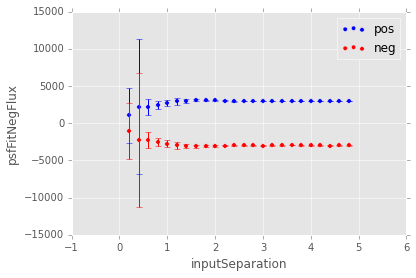

In [22]:
tmp_df = df.groupby('inputSeparation').median()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').mad() * 1.
ax = tmp_df.plot(x='inputSeparation', y='psfFitPosFlux', kind='scatter', yerr=tmp_df2['psfFitPosFlux'], color='blue', label='pos')
tmp_df.plot(x='inputSeparation', y='psfFitNegFlux', kind='scatter', yerr=tmp_df2['psfFitNegFlux'], color='red', label='neg', ax=ax)

## Different dipole fluxes (signal-to-noise)

In [23]:
from joblib import Parallel, delayed  
import multiprocessing

## Cool, get argument names for the function, and turn it into a named tuple...
varNames = makeDipoleAndTestDipoleFit.__code__.co_varnames[:makeDipoleAndTestDipoleFit.__code__.co_argcount]
varTuple = namedtuple("varTuple", varNames)

orientations = np.arange(0.0, 360.0, 36.0)
separations = np.arange(0.2, 5.0, 0.2)
fluxes = np.arange(250., 6000., 250.)

inputs = [varTuple(w=51, h=51, xc=25., yc=25., psfWidth=2.0, separation=sep, rotAngle=rot, 
                         flux=flux, verbose=False) for flux in fluxes for rot in orientations for sep in separations]


def processInput(i):
    #print i.flux ##i.separation, i.rotAngle
    output = makeDipoleAndTestDipoleFit(w=i.w, h=i.h, xc=i.xc, yc=i.yc, psfWidth=i.psfWidth, separation=i.separation, 
                               rotAngle=i.rotAngle, flux=i.flux, verbose=i.verbose)
    return output


num_cores = multiprocessing.cpu_count() / 2
##print num_cores

# results3 = [makeDipoleAndTestDipoleFit(w=51, h=51, xc=25., yc=25., psfWidth=2.0, separation=sep, rotAngle=rot[i], 
#                                        flux=3000.0) for rot in orientations for sep in separations]
results3 = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)
# results3 = [processInput(i) for i in inputs]

In [24]:
df = pd.DataFrame([res._asdict() for res in results3])
print df.shape
df['rmsCentroidPos'] = np.sqrt((df.inputPosCentroidX - df.psfFitPosCentroidY)**2. + \
                               (df.inputPosCentroidY - df.psfFitPosCentroidX)**2.)

df['rmsCentroidNeg'] = np.sqrt((df.inputNegCentroidX - df.psfFitNegCentroidY)**2. + \
                               (df.inputNegCentroidY - df.psfFitNegCentroidX)**2.)

#df['rmsCentroidPos2'] = np.sqrt((df.inputPosCentroidX - df.psfFitPosCentroidX)**2. + \
#                               (df.inputPosCentroidY - df.psfFitPosCentroidY)**2.)
#df['rmsCentroidNeg2'] = np.sqrt((df.inputNegCentroidX - df.psfFitNegCentroidX)**2. + \
#                               (df.inputNegCentroidY - df.psfFitNegCentroidY)**2.)
sizeme(df.head())

(5520, 19)


,inputCentroidX,inputCentroidY,inputFlux,inputNegCentroidX,inputNegCentroidY,inputPosCentroidX,inputPosCentroidY,inputRotation,inputSeparation,psfFitCentroidX,...,psfFitNegCentroidX,psfFitNegCentroidY,psfFitNegFlux,psfFitOrientation,psfFitPosCentroidX,psfFitPosCentroidY,psfFitPosFlux,psfFitSignaltoNoise,rmsCentroidPos,rmsCentroidNeg
0,25,25,250,NaN,NaN,NaN,NaN,0,0.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN
1,25,25,250,NaN,NaN,NaN,NaN,0,0.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN
2,25,25,250,NaN,NaN,NaN,NaN,0,0.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN
3,25,25,250,NaN,NaN,NaN,NaN,0,0.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN
4,25,25,250,24.5,25,25.5,25,0,1.0,25.159932,...,25.162604,24.853521,-4077.208267,-0.0781278 rad,25.15726,24.921772,4085.719674,48.510546,0.599232,0.389123


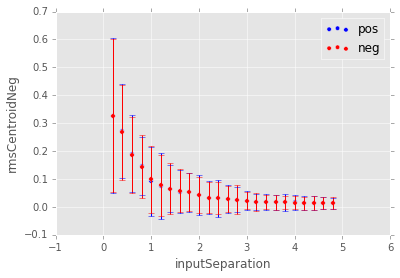

In [25]:
tmp_df = df.groupby('inputSeparation').median()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').mad() * 1.
ax = tmp_df.plot(x='inputSeparation', y='rmsCentroidPos', kind='scatter', yerr=tmp_df2['rmsCentroidPos'], color='blue', label='pos')
tmp_df.plot(x='inputSeparation', y='rmsCentroidNeg', kind='scatter', yerr=tmp_df2['rmsCentroidNeg'], color='red', label='neg', ax=ax)

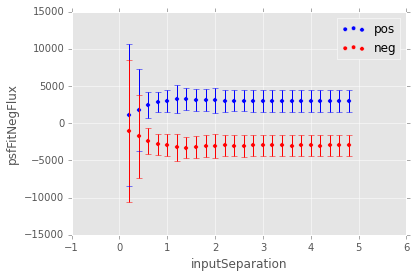

In [26]:
tmp_df = df.groupby('inputSeparation').median()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').mad() * 1.
ax = tmp_df.plot(x='inputSeparation', y='psfFitPosFlux', kind='scatter', yerr=tmp_df2['psfFitPosFlux'], color='blue', label='pos')
tmp_df.plot(x='inputSeparation', y='psfFitNegFlux', kind='scatter', yerr=tmp_df2['psfFitNegFlux'], color='red', label='neg', ax=ax)

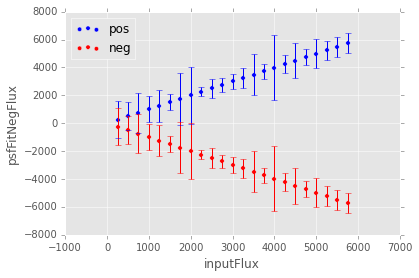

In [27]:
tmp_df = df.groupby('inputFlux').median()
tmp_df['inputFlux'] = tmp_df.index.values
tmp_df2 = df.groupby('inputFlux').mad() * 1.
ax = tmp_df.plot(x='inputFlux', y='psfFitPosFlux', kind='scatter', yerr=tmp_df2['psfFitPosFlux'], color='blue', label='pos')
tmp_df.plot(x='inputFlux', y='psfFitNegFlux', kind='scatter', yerr=tmp_df2['psfFitNegFlux'], color='red', label='neg', ax=ax)

In [28]:
tmp_df = df.groupby('inputFlux')
sizeme(tmp_df.get_group(250.).head())

,inputCentroidX,inputCentroidY,inputFlux,inputNegCentroidX,inputNegCentroidY,inputPosCentroidX,inputPosCentroidY,inputRotation,inputSeparation,psfFitCentroidX,...,psfFitNegCentroidX,psfFitNegCentroidY,psfFitNegFlux,psfFitOrientation,psfFitPosCentroidX,psfFitPosCentroidY,psfFitPosFlux,psfFitSignaltoNoise,rmsCentroidPos,rmsCentroidNeg
0,25,25,250,NaN,NaN,NaN,NaN,0,0.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN
1,25,25,250,NaN,NaN,NaN,NaN,0,0.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN
2,25,25,250,NaN,NaN,NaN,NaN,0,0.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN
3,25,25,250,NaN,NaN,NaN,NaN,0,0.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN
4,25,25,250,24.5,25,25.5,25,0,1.0,25.159932,...,25.162604,24.853521,-4077.208267,-0.0781278 rad,25.15726,24.921772,4085.719674,48.510546,0.599232,0.389123
